In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from datetime import datetime
import seaborn as sns

from funciones_OD import *

#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import RobustScaler
#import keras as keras
#from keras.models import Sequential
#from keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
#import tensorflow as tf


#pd.options.mode.chained_assignment = None  # default='warn' --- Para quitar los warnings de pandas y python
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # Quitar warnings tensorflow

ruta = "G:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
sensor = "pm25"
redondeo = 4
datos = pd.read_csv(ruta+"test_"+archivo+"_outliers.csv",sep=",")
entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")

Se incluyeron 4331 Outliers
Number of training samples: 101059
Training input shape:  (101059, 1, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 1, 32)             256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             3600      
_________________________________________________________________
conv1d_transpose_6 (Conv1DTr (None, 2, 16)             1808      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 16)             0         
_________________________________________________________________
conv1d_transpose_7 (Conv1DTr (None, 4, 32)             3616      
___________________

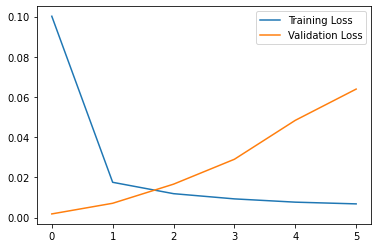

In [180]:
nodo_entreno = [50, 134, 187, 266]
entrenamiento = pd.DataFrame()
prediccion = pd.DataFrame()
variable = sensor
parte_entreno = 0.7

inicio = datetime.now()
#now = datetime.now()
#time_rnn = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

for en in nodo_entreno:
    datos_entreno = entreno.loc[entreno.loc[:,"codigoSerial"] == en]
    #datos_entreno = datos_entreno.iloc[:round(len(datos_entreno)*0.1),:]
    cant_entreno = round(len(datos_entreno)*parte_entreno)
    entrenamiento = pd.concat([entrenamiento,datos_entreno.iloc[:cant_entreno,:]],ignore_index=True)
    prediccion = pd.concat([prediccion,datos_entreno.iloc[cant_entreno:,:]],ignore_index=True)


entrenamiento["fechaHora"] = entrenamiento["fecha"] + " " + entrenamiento["hora"]
diferencias (entrenamiento,[variable],redondeo)

#df_small_noise = entrenamiento.loc[:,["fechaHora", variable+"_dif"]]
df_small_noise = entrenamiento.loc[:,["fechaHora", variable]]
#pd.to_datetime(df_small_noise["fechaHora"])
df_small_noise.set_index("fechaHora", inplace=True)

#df_daily_jumpsup = df_small_noise.copy() 

prediccion["fechaHora"] = prediccion["fecha"] + " " + prediccion["hora"]
prediccion_ori, prediccion, outliers = synthetic_data(prediccion,0.1,20)
diferencias (prediccion,[variable],redondeo)

#df_daily_jumpsup = prediccion.loc[:,["fechaHora", variable+"_dif"]]
df_daily_jumpsup = prediccion.loc[:,["fechaHora", variable]]
pd.to_datetime(df_daily_jumpsup["fechaHora"])
df_daily_jumpsup.set_index("fechaHora", inplace=True)



training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std

print("Number of training samples:", len(df_training_value))

TIME_STEPS = 1

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()
plot_model(model, to_file='model_plot_convo.png', show_shapes=True, show_layer_names=True)

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

fin = datetime.now()
#print("Tiempo RNN:", time_rnn.time())
#print("Tiempo de entrenamiento:",tiempo_entrenamiento)
print("Tiempo total:", fin-inicio)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

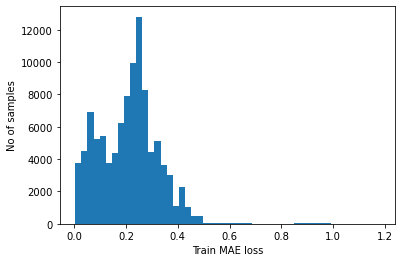

Reconstruction error threshold:  1.180429283990529


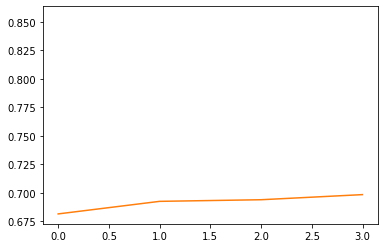

In [181]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

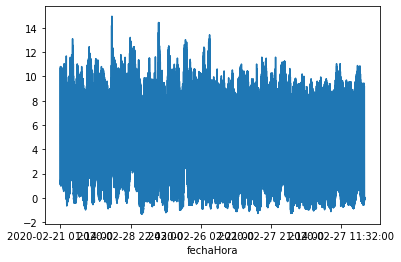

Test input shape:  (43310, 1, 1)


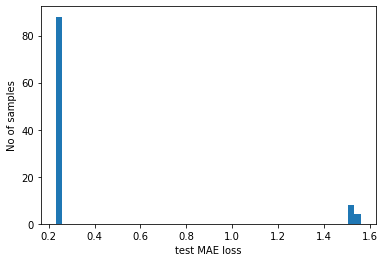

Number of anomaly samples:  4328
Indices of anomaly samples:  (array([   28,    35,    41, ..., 43253, 43256, 43263], dtype=int64),)


In [182]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss[0:100], bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [205]:
lista_pred = []
for i in range (len(x_test_pred)):
    lista_pred.append(np.mean(x_test_pred[i]))
#print(lista_pred[0:50])

# lista_test = []
# for i in range (len(x_test)):
#     lista_test.append(x_test[i][0][0])
# print(lista_test[0:50])


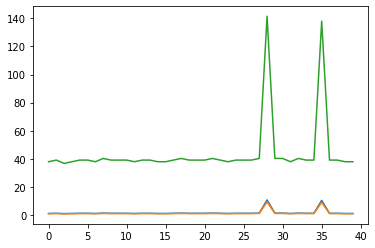

In [208]:
#test_datos = x_test_pred[0].reshape(2).tolist() + x_test_pred[3].reshape(2).tolist()
#test_datos.append(x_test_pred[0].reshape(100).tolist())
#test_datos.append(x_test_pred[1].reshape(100).tolist())
plt.plot(df_test_value.values[0:40])
plt.plot(lista_pred[0:40])
plt.plot(prediccion.pm25.values[0:40])
#plt.plot(test_datos[0:1])
plt.show()

#df_daily_jumpsup
#df_small_noise
#df_test_value.values
#x_test_pred[1].reshape(100).tolist()
#test_mae_loss
#test_datos[0:100]

Precisión: 1.0
Exhaustividad: 0.9993073193257908
F1: 0.9996535396697078
Exactitud: 0.9999307319325791



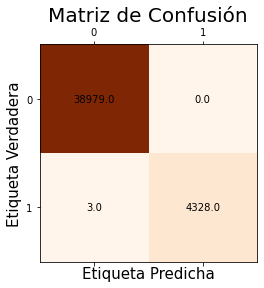

In [203]:
real = prediccion.pm25_outlier.tolist()
real = ['S' if value!='N' else value for value in real]
predicho = ['S' if value==True else value for value in anomalies]
predicho = ['N' if value==False else value for value in predicho]
confu_matrix (real,predicho)